In [1]:
import os
import copy
import functools
from collections import defaultdict

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
cavity_path = "../data/20210810_diosBL_bb02_cavity/"
siv_path = "../data/20210810_diosBL_bb02_SiV_645_6662/"

cavity_files = ["dataset_maxpol_raw-counts_x_16_28_33.txt", "dataset_maxpol_raw-counts_16_28_33.txt"]

# List of 2-tuples, first is the avg file (which contains the freq values), second is the scans file
siv_files = [["645/sweeper_fwd_avg_19_30_06.txt", "645/sweeper_fwd_scans_19_30_05.txt"],  
             ["6662/sweeper_fwd_avg_19_41_47.txt", "6662/sweeper_fwd_scans_19_41_47.txt"]]

# Plot data

## Plot Cavity Data

Text(0, 0.5, 'Cavity Intensity')

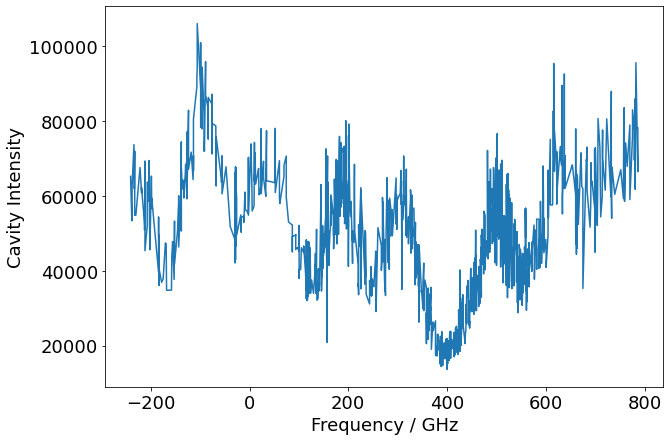

In [3]:
plt.figure(figsize=[10, 7])

cavity_freqs = np.loadtxt(cavity_path + cavity_files[0])
cavity_intensity = np.loadtxt(cavity_path + cavity_files[1])

cavity_freqs = 1000 * (cavity_freqs - 406) # Re-center, convert to GHz

##### TODO: FILTER ##################
cavity_intensity = cavity_intensity[cavity_freqs<800]
cavity_freqs = cavity_freqs[cavity_freqs<800]
#####################################

plt.plot(cavity_freqs, cavity_intensity)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")

## Plot SiV Data

Loaded file ../data/20210810_diosBL_bb02_SiV_645_6662/645/sweeper_fwd_avg_19_30_06.txt!
Loaded file ../data/20210810_diosBL_bb02_SiV_645_6662/6662/sweeper_fwd_avg_19_41_47.txt!


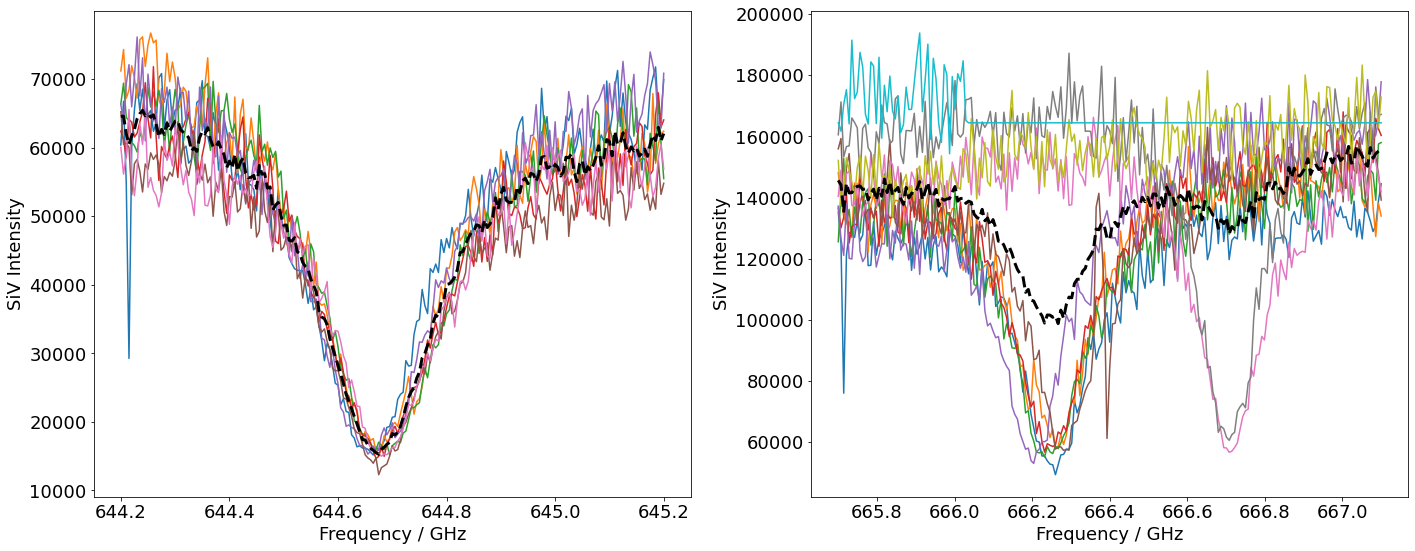

In [4]:
siv_avg_scans = []

ncols = 2
nrows = int(np.ceil(len(siv_files) / ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=[20, 8])
# Reshape a 1D array of subplots into 2D for consistent indenxing
if ax.ndim == 1: ax = ax.reshape(-1, ax.size)

for idx, siv_files_tuple in enumerate(siv_files):
    # Extract freq from the avg scan file
    siv_freqs, _ = np.loadtxt(siv_path + siv_files_tuple[0])
    print(f"Loaded file {siv_path + siv_files_tuple[0]}!")
    
    siv_freqs = 1000 * (siv_freqs - 406) # Convert to GHz

    # Extract data from the SiV scan file
    siv_data = np.loadtxt(siv_path + siv_files_tuple[1])

    # Plot each scan from the file
    for siv_series in siv_data:
        ax[idx//ncols, idx%ncols].plot(siv_freqs, siv_series)
    
    # Plot the average scans
    siv_avg_scans.append(np.mean(siv_data, axis=0))
    ax[idx//ncols, idx%ncols].plot(siv_freqs, np.mean(siv_data, axis=0), 'k--', lw=3)

    axes = ax[idx//ncols, idx%ncols]
    axes.set_xlabel("Frequency / GHz")
    axes.set_ylabel("SiV Intensity")
        
fig.tight_layout()

# --------------------
# Fit Cavity Spectrum

### Unfiltered

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 2037
    # variables        = 4
    chi-square         = 2.3638e+11
    reduced chi-square = 1.1627e+08
    Akaike info crit   = 37834.0096
    Bayesian info crit = 37856.4865
[[Variables]]
    w_c:    400.281647 +/- 1.24138532 (0.31%) (init = 400)
    k_in:   41.4336574 +/- 1.96637725 (4.75%) (init = 30)
    k_tot:  53.9721451 +/- 2.31506828 (4.29%) (init = 50)
    A:      57960.5182 +/- 384.527902 (0.66%) (init = 60000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.991
    C(k_tot, A)    =  0.609
    C(k_in, A)     =  0.563
    C(w_c, k_in)   = -0.177
    C(w_c, k_tot)  = -0.165


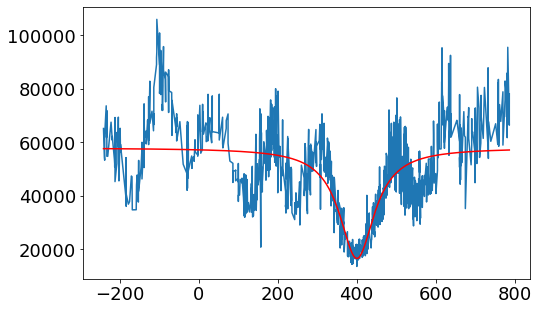

In [69]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=400, min=380, max=420),
    Parameter('k_in', value=30, min=0, max=1000),
    Parameter('k_tot', value=50, min=0, max=1000),
    Parameter('A', value=60000, min=10000, max=200000),
    Parameter('B', value=0, vary=False),
)

cavity_results = cavity_ref_model.fit(cavity_intensity, params, w=cavity_freqs)
lmfit.report_fit(cavity_results)

plt.plot(cavity_freqs, cavity_intensity)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity / cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs)

### Filtered Cavity

In [6]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 145
    # data points      = 1508
    # variables        = 4
    chi-square         = 1.4413e+11
    reduced chi-square = 95832478.1
    Akaike info crit   = 27718.1879
    Bayesian info crit = 27739.4620
[[Variables]]
    w_c:    400.261049 +/- 1.04483020 (0.26%) (init = 400)
    k_in:   37.2458180 +/- 1.50655809 (4.04%) (init = 30)
    k_tot:  49.1010243 +/- 1.76397985 (3.59%) (init = 50)
    A:      58727.7478 +/- 357.289621 (0.61%) (init = 60000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.988
    C(k_tot, A)    =  0.422
    C(k_in, A)     =  0.369
    C(w_c, k_in)   = -0.162
    C(w_c, k_tot)  = -0.145


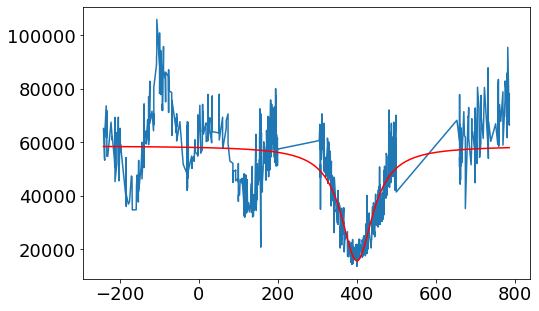

In [70]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(200, 300), (500, 650)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=400, min=380, max=420),
    Parameter('k_in', value=30, min=0, max=1000),
    Parameter('k_tot', value=50, min=0, max=1000),
    Parameter('A', value=60000, min=10000, max=200000),
    Parameter('B', value=0, vary=False),
)

cavity_filtered_results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity_filtered / cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs_filtered)

In [71]:
# Compute the correlations and error in the fits using MCMC
# data_noise is a 3-tuple (expected noise in data, min estimate, max estimate)
# emcee_results, emcee_mle_params = mcmc(cavity_freqs_filtered, cavity_intensity_filtered, cavity_ref_model, cavity_filtered_results, 
#                                        data_noise=[10000, 1000, 30000], input_params={"steps": 6000})

# Fit SiV Spectrum - 645

## Fit Average Scans

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 312
    # data points      = 201
    # variables        = 5
    chi-square         = 7.4002e+08
    reduced chi-square = 3775626.76
    Akaike info crit   = 3048.89623
    Bayesian info crit = 3065.41275
[[Variables]]
    w_up:      644.287783 +/- 0.01339256 (0.00%) (init = 644.5)
    g_up:      9.51935016 +/- 0.16710231 (1.76%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       400.261 (fixed)
    k_in:      21.1821536 +/- 0.56482844 (2.67%) (init = 37)
    k_tot:     47.0000000 +/- 1.0561e-05 (0.00%) (init = 49)
    A:         66734.3246 +/- 304.488015 (0.46%) (init = 12000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_up, g_up) = -0.997
    C(w_up, k_in) =  0.903
    C(g_up, k_in) = -0.901
    C(g_up, A)    =  0.712
    C(w_up, A)    = -0.708
    C(k_in, A)    = -0.478


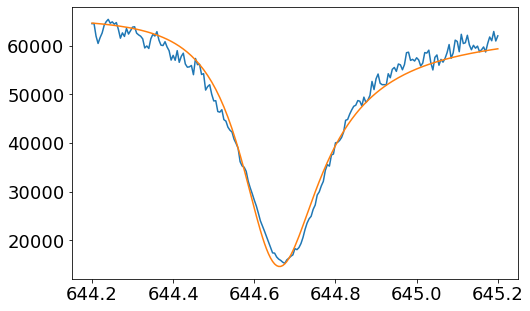

In [72]:
siv_index = 0

# Extract freq from the avg scan file
siv_freqs, _ = np.loadtxt(siv_path + siv_files[siv_index][0])
# Convert to GHz
siv_freqs = 1000 * (siv_freqs - 406) 
# Extract data from the SiV scan file
siv_data = np.loadtxt(siv_path + siv_files[siv_index][1])
siv_645_avg_data = np.mean(siv_data, axis=0)

params = Parameters()
params.add_many(
    Parameter('w_up', value=644.5, min=644, max=645),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=400.261, vary=False),
    Parameter('k_in', value=37, min=10, max=56),
    Parameter('k_tot', value=49, min=47, max=56),
    Parameter('A', value=12000, min=5000, max=90000),
    Parameter('B', value=0, vary=False),
)

siv_645_avg_results = single_siv_ref_model.fit(siv_645_avg_data, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(siv_645_avg_results)

plt.plot(siv_freqs, siv_645_avg_data)
plt.plot(siv_freqs, single_siv_ref_model.eval(siv_645_avg_results.params, w=siv_freqs))

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 642
    # data points      = 201
    # variables        = 5
    chi-square         = 2.8704e+08
    reduced chi-square = 1464485.36
    Akaike info crit   = 2858.53666
    Bayesian info crit = 2875.05319
[[Variables]]
    w_up:      644.000000 +/- 1.1763e-06 (0.00%) (init = 644.5)
    g_up:      12.7682670 +/- 0.00717707 (0.06%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       400.261 (fixed)
    k_in:      11.9864581 +/- 0.11648939 (0.97%) (init = 37)
    k_tot:     27.5378978 +/- 0.49522268 (1.80%) (init = 49)
    A:         65983.6055 +/- 199.135491 (0.30%) (init = 12000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)     =  0.775
    C(k_tot, A)    =  0.753
    C(k_in, k_tot) =  0.697
    C(g_up, k_tot) = -0.419
    C(g_up, k_in)  = -0.304
    C(g_up, A)     = -0.273


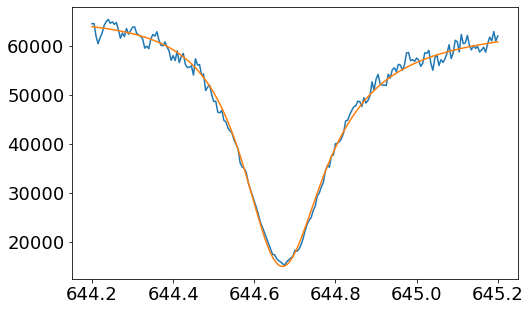

In [76]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=644.5, min=644, max=645),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=400.261, vary=False),
    Parameter('k_in', value=37, min=0, max=56),
    Parameter('k_tot', value=49, min=0, max=56),
    Parameter('A', value=12000, min=5000, max=90000),
    Parameter('B', value=0, vary=False),
)

siv_645_avg_results = single_siv_ref_model.fit(siv_645_avg_data, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(siv_645_avg_results)

plt.plot(siv_freqs, siv_645_avg_data)
plt.plot(siv_freqs, single_siv_ref_model.eval(siv_645_avg_results.params, w=siv_freqs))

In [38]:
# Compute the correlations and error in the fits using MCMC
# data_noise is a 3-tuple (expected noise in data, min estimate, max estimate)
# emcee_results, emcee_mle_params = mcmc(siv_freqs, siv_fwd_7_data, single_siv_ref_model, siv_fwd_7_results, 
#                                        data_noise=[500, 100, 2000], input_params={"steps": 12000})

# Optimize detuning for cavity

In [43]:
fit_results = siv_645_avg_results

# Copy the fitted parameters into a Cavity object
c = Cavity({"w_c" : fit_results.params["w_c"].value - fit_results.params["w_up"].value,    
            "k_in" : fit_results.params["k_in"].value, 
            "k_tot" : fit_results.params["k_tot"].value}, 
              
           {"w_up" : 0, # Fix this to be 0, shift the cavity freq instead
            "g_up" : fit_results.params["g_up"].value,         
            "gamma_up" : fit_results.params["gamma_up"].value,  
            "g_down" : fit_results.params["g_up"].value,       
            "gamma_down" : fit_results.params["gamma_up"].value})
fit_results

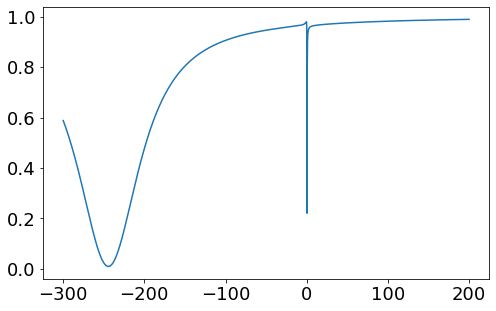

In [44]:
# Plot the current reflectance spectrum of the SiV in the Cavity
# Make sure that the range that we want to search is plotted in here!
w_arr = np.linspace(-300, 200, 10000)
plt.plot(w_arr, c.reflectance(w_arr, 1), label="up")

Optimum value function of 3.37 achieved at freq = 0.187, delta = -76.0, splitting = -1.0
Maximum optimization value = 3.37 located at frequency 0.188
Maximum contrast = 38.1 located at frequency 0.193
Lower reflectivity = 0.0243, higher reflectivity = 0.925


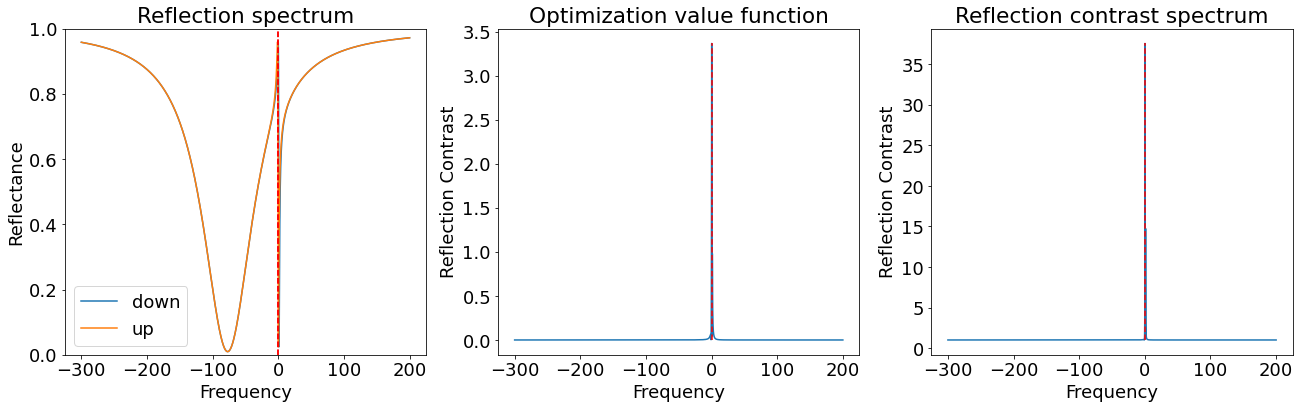

<Figure size 576x360 with 0 Axes>

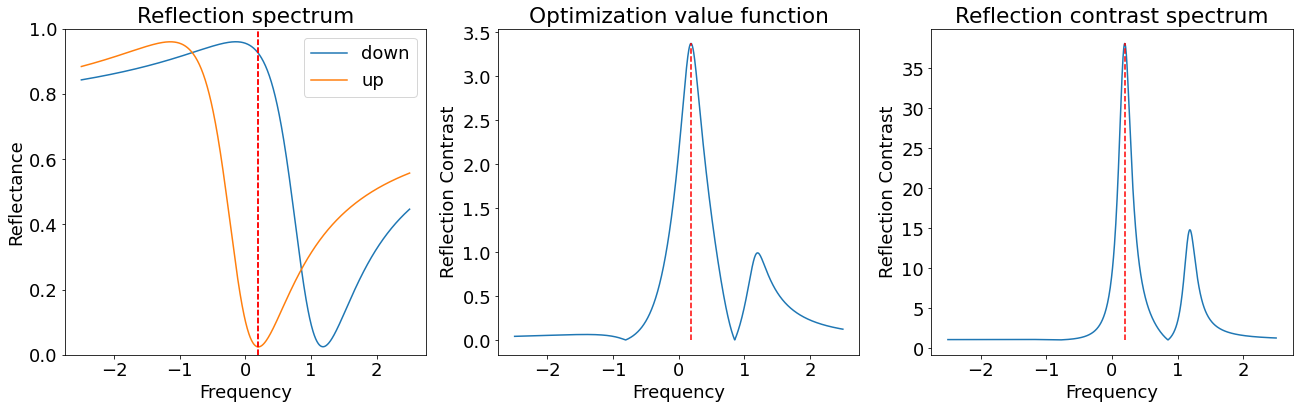

In [77]:
# Find the best detuning and splitting
(w_opt, delta_opt, splitting_opt), spin_contrast_opt = c.optimize_spin_contrast_no_SiVmodel(
            w_0=0, delta_0=-10, splitting_0=-0.5,
            w_bounds=(min(w_arr), max(w_arr)), 
            delta_bounds=(-max(np.abs(w_arr)), 0), # WLOG since the cavity is symmetric
            splitting_bounds=(-1.0, 1.0)) # Based on SiV params, max B field

print("Optimum value function of {:.3} achieved at freq = {:.3}, delta = {:.3}, splitting = {:.3}".format(spin_contrast_opt, w_opt, delta_opt, splitting_opt))

# PLot the zoomed-out spectrum
c.plot_reflection_contrast_no_SiVmodel(w_arr, delta_opt, splitting_opt, print_output=False)
# PLot the zoomed-in spectrum
plt.figure()
w_arr_zoom = np.linspace(-2.5, 2.5, 1000)
c.plot_reflection_contrast_no_SiVmodel(w_arr_zoom, delta_opt, splitting_opt)

# ---------------------------------
# Fit SiV Spectrum - 6662

## Fit Average Scans

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 276
    # data points      = 201
    # variables        = 5
    chi-square         = 1.5878e+10
    reduced chi-square = 81009747.1
    Akaike info crit   = 3665.16285
    Bayesian info crit = 3681.67937
[[Variables]]
    w_up:      666.127430 +/- 0.03854325 (0.01%) (init = 666.2)
    g_up:      5.43069982 +/- 0.73382480 (13.51%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       400.261 (fixed)
    k_in:      41.5771168 +/- 10.1981595 (24.53%) (init = 30)
    k_tot:     47.0000000 +/- 4.4697e-05 (0.00%) (init = 49)
    A:         141383.624 +/- 3856.16303 (2.73%) (init = 160000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_up, g_up) = -0.997
    C(w_up, k_in) =  0.990
    C(g_up, k_in) = -0.988
    C(g_up, A)    =  0.982
    C(w_up, A)    = -0.980
    C(k_in, A)    = -0.978


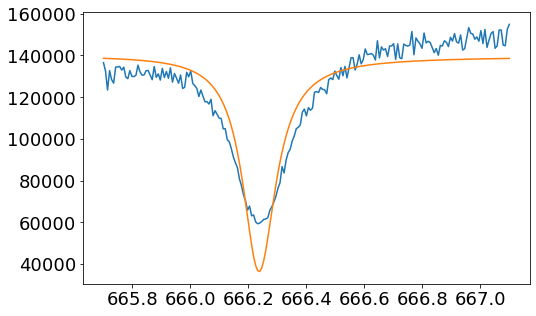

In [21]:
siv_index = 1

# Extract freq from the avg scan file
siv_freqs, _ = np.loadtxt(siv_path + siv_files[siv_index][0])
# Convert to GHz
siv_freqs = 1000 * (siv_freqs - 406) 
# Extract data from the SiV scan file
siv_data = np.loadtxt(siv_path + siv_files[siv_index][1])

##### TODO: FILTER OUT THE FREQ JUMP ##################
siv_data = siv_data[:5]
#####################################

siv_6662_avg_data = np.mean(siv_data, axis=0)

params = Parameters()
params.add_many(
    Parameter('w_up', value=666.2, min=666, max=666.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=400.261, vary=False),
    Parameter('k_in', value=30, min=10, max=49),
    Parameter('k_tot', value=49, min=47, max=56),
    Parameter('A', value=160000, min=100000, max=200000),
    Parameter('B', value=0, vary=False),
)

siv_6662_avg_results = single_siv_ref_model.fit(siv_6662_avg_data, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(siv_6662_avg_results)

plt.plot(siv_freqs, siv_6662_avg_data)
plt.plot(siv_freqs, single_siv_ref_model.eval(siv_6662_avg_results.params, w=siv_freqs))

In [15]:
# Compute the correlations and error in the fits using MCMC
# data_noise is a 3-tuple (expected noise in data, min estimate, max estimate)
# emcee_results, emcee_mle_params = mcmc(siv_freqs, siv_fwd_7_data, single_siv_ref_model, siv_fwd_7_results, 
#                                        data_noise=[500, 100, 2000], input_params={"steps": 12000})

# Optimize detuning for cavity

In [16]:
fit_results = siv_6662_avg_results

# Copy the fitted parameters into a Cavity object
c = Cavity({"w_c" : fit_results.params["w_c"].value - fit_results.params["w_up"].value,    
            "k_in" : fit_results.params["k_in"].value, 
            "k_tot" : fit_results.params["k_tot"].value}, 
              
           {"w_up" : 0, # Fix this to be 0, shift the cavity freq instead
            "g_up" : fit_results.params["g_up"].value,         
            "gamma_up" : fit_results.params["gamma_up"].value,  
            "g_down" : fit_results.params["g_up"].value,       
            "gamma_down" : fit_results.params["gamma_up"].value})
fit_results

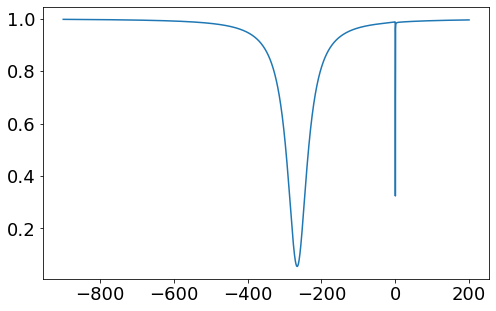

In [17]:
# Plot the current reflectance spectrum of the SiV in the Cavity
# Make sure that the range that we want to search is plotted in here!
w_arr = np.linspace(-900, 200, 10000)
plt.plot(w_arr, c.reflectance(w_arr, 1), label="up")

Optimum value function of 25.4 achieved at freq = -0.366, delta = -97.3, spliting = -1.0
Maximum optimization value = 9.28 located at frequency -0.368
Maximum contrast = 4.65e+04 located at frequency 0.628
Lower reflectivity = 0.768, higher reflectivity = 1.65e-05


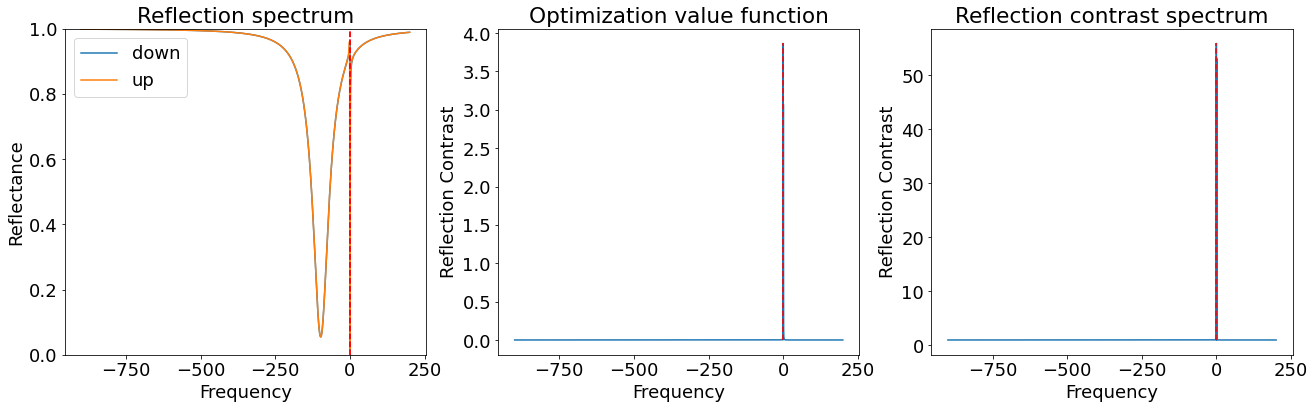

<Figure size 576x360 with 0 Axes>

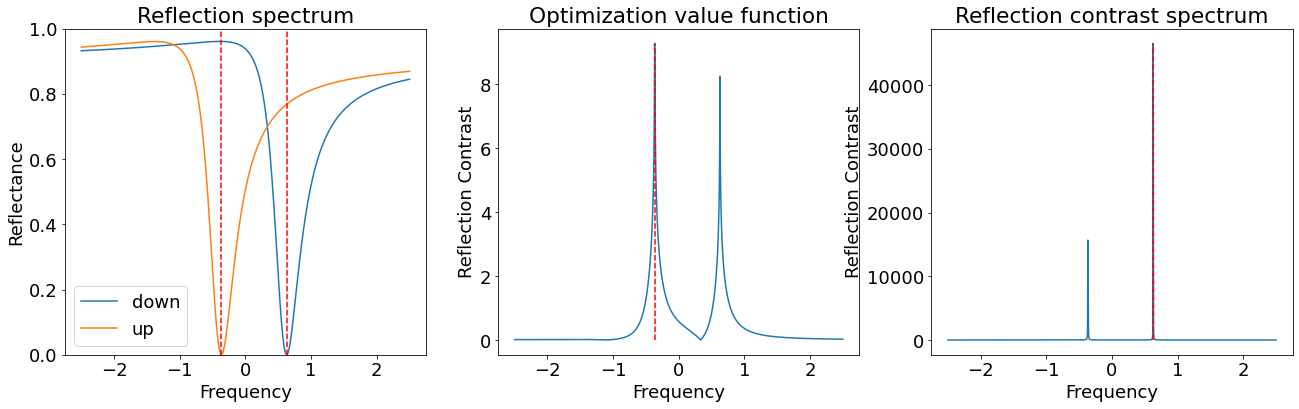

In [18]:
# Find the best detuning and splitting
(w_opt, delta_opt, splitting_opt), spin_contrast_opt = c.optimize_spin_contrast_no_SiVmodel(
            w_0=0, delta_0=-10, splitting_0=-0.5,
            w_bounds=(min(w_arr), max(w_arr)), 
            delta_bounds=(-max(np.abs(w_arr)), 0), # WLOG since the cavity is symmetric
            splitting_bounds=(-1.0, 1.0)) # Based on SiV params, max B field

print("Optimum value function of {:.3} achieved at freq = {:.3}, delta = {:.3}, splitting = {:.3}".format(spin_contrast_opt, w_opt, delta_opt, splitting_opt))

# PLot the zoomed-out spectrum
c.plot_reflection_contrast_no_SiVmodel(w_arr, delta_opt, splitting_opt, print_output=False)
# PLot the zoomed-in spectrum
plt.figure()
w_arr_zoom = np.linspace(-2.5, 2.5, 1000)
c.plot_reflection_contrast_no_SiVmodel(w_arr_zoom, delta_opt, splitting_opt)